In [324]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import statsmodels.formula.api as smf

In [325]:
rdp = pd.read_excel('data.xlsx', index_col=0)

rdp.head()

,GDPPOT_20230726,GDPC1_20230727
observation_date,,
1950-01-01,2218.566586,2186.365
1950-04-01,2248.161822,2253.045
1950-07-01,2277.049682,2340.112
1950-10-01,2306.715167,2384.920
1951-01-01,2336.504742,2417.311


<Axes: xlabel='observation_date', ylabel='GDPC1_20230727'>

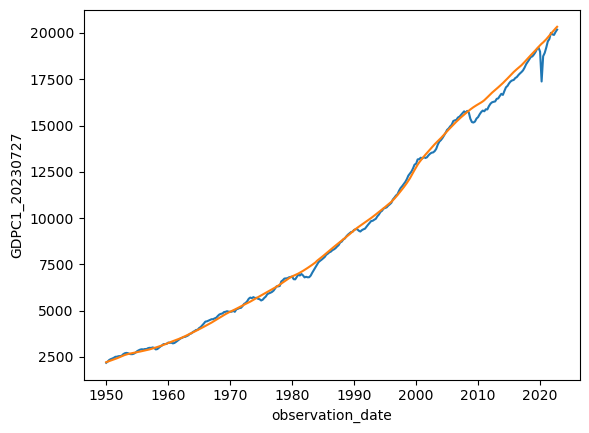

In [326]:
rdp = rdp.dropna()

sns.lineplot(data=rdp, x='observation_date', y='GDPC1_20230727')
sns.lineplot(data=rdp, x='observation_date', y='GDPPOT_20230726')

In [327]:
nrou = pd.read_csv('NROU.csv', index_col=0)

nrou.head()

,NROU
DATE,
1949-01-01,5.255053
1949-04-01,5.261516
1949-07-01,5.268013
1949-10-01,5.274564
1950-01-01,5.281182


In [328]:
unrate = pd.read_csv('UNRATE.csv', index_col=0)

unrate.head()

,UNRATE
DATE,
1948-01-01,3.7333333333333333
1948-04-01,3.6666666666666667
1948-07-01,3.7666666666666667
1948-10-01,3.8333333333333333
1949-01-01,4.6666666666666667


In [329]:
unemployment = pd.merge(left=unrate, right=nrou, left_index=True, right_index=True)

unemployment.head()

,UNRATE,NROU
DATE,,
1949-01-01,4.6666666666666667,5.255053
1949-04-01,5.8666666666666667,5.261516
1949-07-01,6.7000000000000000,5.268013
1949-10-01,6.9666666666666667,5.274564
1950-01-01,6.4000000000000000,5.281182


<Axes: xlabel='DATE', ylabel='UNRATE'>

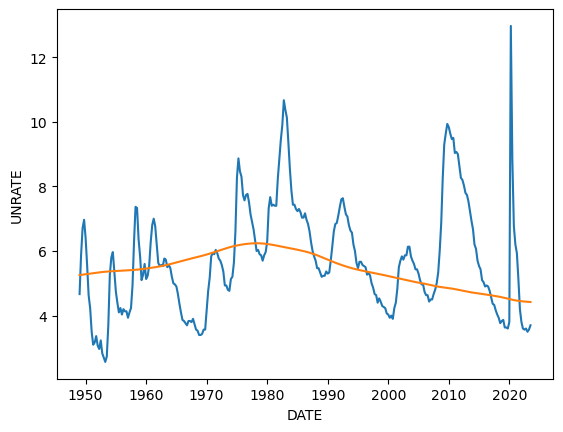

In [330]:
unemployment = unemployment[:-1]
unemployment['UNRATE'] = unemployment['UNRATE'].astype(float)
unemployment.index = pd.to_datetime(unemployment.index)

sns.lineplot(data=unemployment, x='DATE', y='UNRATE')
sns.lineplot(data=unemployment, x='DATE', y='NROU')

In [331]:
data = pd.merge(left=unemployment, right=rdp, left_index=True, right_index=True)

data.head()

,UNRATE,NROU,GDPPOT_20230726,GDPC1_20230727
1950-01-01,6.400000,5.281182,2218.566586,2186.365
1950-04-01,5.566667,5.287866,2248.161822,2253.045
1950-07-01,4.633333,5.294604,2277.049682,2340.112
1950-10-01,4.233333,5.301367,2306.715167,2384.920
1951-01-01,3.500000,5.308113,2336.504742,2417.311


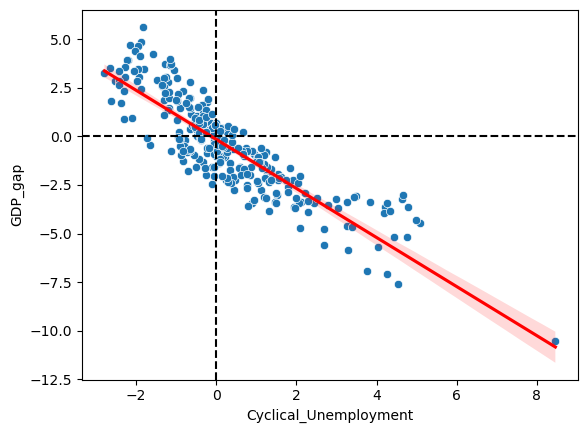

In [332]:
data['GDP_gap'] = (data['GDPC1_20230727'] - data['GDPPOT_20230726']) / data['GDPPOT_20230726'] * 100

data['Cyclical_Unemployment'] = data['UNRATE'] - data['NROU']

sns.scatterplot(data=data, x='Cyclical_Unemployment', y='GDP_gap')
sns.regplot(data=data, x='Cyclical_Unemployment', y='GDP_gap', scatter=False, color='r')
plt.axhline(y=0, color='k', linestyle='--')
plt.axvline(x=0, color='k', linestyle='--')
plt.show()

In [333]:
data = data[data['Cyclical_Unemployment'] < 6]

In [334]:
model = sm.OLS(data['GDP_gap'], sm.add_constant(data['Cyclical_Unemployment'])).fit()

print(model.summary2())

                   Results: Ordinary least squares
Model:                 OLS               Adj. R-squared:      0.749   
Dependent Variable:    GDP_gap           AIC:                 925.8965
Date:                  2023-12-16 02:21  BIC:                 933.2431
No. Observations:      291               Log-Likelihood:      -460.95 
Df Model:              1                 F-statistic:         866.7   
Df Residuals:          289               Prob (F-statistic):  5.62e-89
R-squared:             0.750             Scale:               1.4008  
----------------------------------------------------------------------
                       Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
----------------------------------------------------------------------
const                 -0.1597   0.0705  -2.2651 0.0242 -0.2985 -0.0209
Cyclical_Unemployment -1.2644   0.0429 -29.4405 0.0000 -1.3490 -1.1799
----------------------------------------------------------------------
Omnibus:                 2

Метод Ходрика-Прескотта (HP-фильтр)

In [335]:
data_last = data[data.index.year > 2008].copy()
data_last.index.name = 'date'

In [336]:
model = sm.OLS(data_last['GDP_gap'], sm.add_constant(data_last['Cyclical_Unemployment'])).fit()

print(model.summary2())

                   Results: Ordinary least squares
Model:                 OLS               Adj. R-squared:      0.793   
Dependent Variable:    GDP_gap           AIC:                 104.6593
Date:                  2023-12-16 02:21  BIC:                 108.6739
No. Observations:      55                Log-Likelihood:      -50.330 
Df Model:              1                 F-statistic:         208.4   
Df Residuals:          53                Prob (F-statistic):  5.24e-20
R-squared:             0.797             Scale:               0.37883 
----------------------------------------------------------------------
                       Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
----------------------------------------------------------------------
const                 -1.4604   0.1044 -13.9944 0.0000 -1.6697 -1.2510
Cyclical_Unemployment -0.5891   0.0408 -14.4366 0.0000 -0.6709 -0.5072
----------------------------------------------------------------------
Omnibus:                 0

In [337]:
from statsmodels.stats.diagnostic import linear_reset

model = smf.ols('GDP_gap ~ Cyclical_Unemployment', data=data_last).fit()
reset = linear_reset(model, power=2)

reset.pvalue

c:\ProgramData\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


0.0320106578167854

In [338]:
model = smf.ols('GDP_gap ~ Cyclical_Unemployment + np.square(Cyclical_Unemployment)', data=data_last).fit()
reset = linear_reset(model, power=2)

reset.pvalue

c:\ProgramData\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


0.4333712752234451

In [339]:
model = smf.ols('GDP_gap ~ Cyclical_Unemployment + np.square(Cyclical_Unemployment)', data_last).fit()

print(model.summary2())

                         Results: Ordinary least squares
Model:                    OLS                   Adj. R-squared:          0.807   
Dependent Variable:       GDP_gap               AIC:                     101.9992
Date:                     2023-12-16 02:21      BIC:                     108.0212
No. Observations:         55                    Log-Likelihood:          -48.000 
Df Model:                 2                     F-statistic:             113.6   
Df Residuals:             52                    Prob (F-statistic):      1.06e-19
R-squared:                0.814                 Scale:                   0.35475 
---------------------------------------------------------------------------------
                                  Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------
Intercept                        -1.5008   0.1027 -14.6095 0.0000 -1.7069 -1.2947
Cyclical_Unemployment            -0.8086 

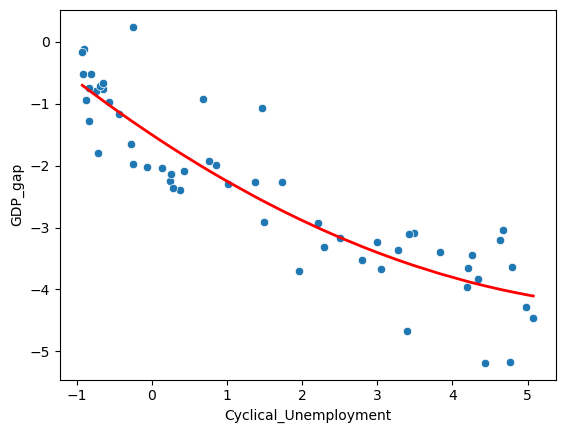

In [340]:
sns.scatterplot(y=data_last['GDP_gap'], x=data_last['Cyclical_Unemployment'])
sns.lineplot(y=model.fittedvalues, x=data_last['Cyclical_Unemployment'], color='r', linewidth=2)

plt.show()

In [341]:
data_pred = data[data.index.year < 2008].copy()

model = sm.OLS(data_pred['GDP_gap'], sm.add_constant(data_pred['Cyclical_Unemployment'])).fit()

print(model.summary2())

                   Results: Ordinary least squares
Model:                 OLS               Adj. R-squared:      0.818   
Dependent Variable:    GDP_gap           AIC:                 662.6620
Date:                  2023-12-16 02:21  BIC:                 669.5554
No. Observations:      232               Log-Likelihood:      -329.33 
Df Model:              1                 F-statistic:         1037.   
Df Residuals:          230               Prob (F-statistic):  3.60e-87
R-squared:             0.818             Scale:               1.0099  
----------------------------------------------------------------------
                       Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
----------------------------------------------------------------------
const                 -0.1140   0.0660  -1.7278 0.0854 -0.2440  0.0160
Cyclical_Unemployment -1.5805   0.0491 -32.1972 0.0000 -1.6772 -1.4838
----------------------------------------------------------------------
Omnibus:                6.

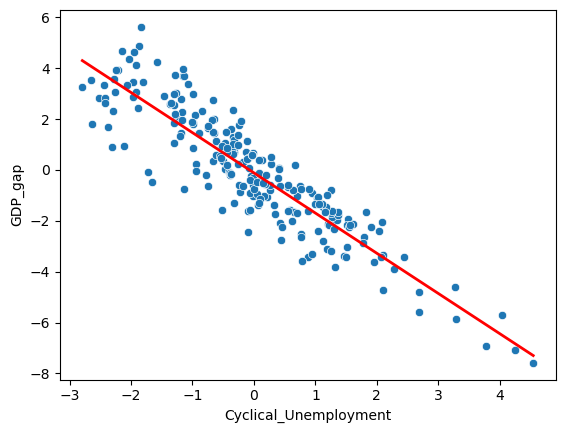

In [342]:
sns.scatterplot(y=data_pred['GDP_gap'], x=data_pred['Cyclical_Unemployment'])
sns.lineplot(y=model.fittedvalues, x=data_pred['Cyclical_Unemployment'], color='r', linewidth=2)

plt.show()

In [343]:
model = smf.ols('GDP_gap ~ Cyclical_Unemployment', data=data_pred).fit()
reset = linear_reset(model, power=2)

reset.pvalue

c:\ProgramData\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


0.3533378331510668